# Turing-style hybrid model (HybridModel user API)

This notebook rewrites your **Schnakenberg/Turing** hybrid setup using the **HybridModel** user API:

- Define domain, diffusion, conversion
- Provide PDE reaction terms with a friendly `lambda U, V, r: (dU, dV)`
- Add macroscopic reactions that auto-decompose into hybrid SRCM reactions
- Provide cosine-perturbed steady-state **SSA initial conditions** (PDE starts at 0)


In [6]:
import sys
from pathlib import Path

repo_root = Path.cwd().parent   # examples/ → repo/
sys.path.append(str(repo_root))

In [7]:
import numpy as np

from srcm_engine import HybridModel
from srcm_engine.results.io import save_npz, load_npz
from srcm_engine.animation_util import AnimationConfig, animate_results, plot_mass_time_series


## 1) Parameters

In [8]:
# Controls
N_COMPARTMENTS = 8
OMEGA = 500
PERT_A = 0.07

total_time = 100.0
dt = 0.001

# "bar" parameters (dimensionless)
bar_r_11 = 1.0
bar_r_12 = 1.0
bar_r_2  = 2.0
bar_r_3  = 0.6

# Rescale (match your SSA scaling)
r_11 = bar_r_11 / OMEGA
r_12 = bar_r_12 / OMEGA
r_2  = bar_r_2  / OMEGA
r_3  = bar_r_3

# Domain / diffusion
L = 1.0
K = N_COMPARTMENTS
pde_multiple = 4
boundary = "zero-flux"

Du = 2.782559e-03
Dv = Du * 24.7

# Conversion
threshold_particles = 80
conversion_rate = 1.0


## 2) Build model with HybridModel

In [9]:
m = HybridModel(species=["U", "V"])

m.domain(L=L, K=K, pde_multiple=pde_multiple, boundary=boundary)
m.diffusion(U=Du, V=Dv)
m.conversion(threshold=threshold_particles, rate=conversion_rate)

# PDE reaction terms on integrated mass per PDE cell
# dU = r11*U^2 - r2*U*V
# dV = r12*U^2 - r3*V
m.reaction_terms(
    lambda U, V, r: (
        r["r_11"] * U**2 - r["r_2"] * U * V,
        r["r_12"] * U**2 - r["r_3"] * V,
    )
)

# Macroscopic reactions (auto-decompose into hybrid reactions)
m.add_reaction({"U": 2}, {"U": 3},          rate_name="r_11")
m.add_reaction({"U": 2}, {"U": 2, "V": 1},  rate_name="r_12")
m.add_reaction({"U": 1, "V": 1}, {"V": 1},  rate_name="r_2")
m.add_reaction({"V": 1}, {},               rate_name="r_3")

m.build(rates={"r_11": r_11, "r_12": r_12, "r_2": r_2, "r_3": r_3})

m.describe_reactions()


0.0
0.0
0.0
0.0

 Reaction system description

=== Macroscopic reactions ===
[1] 2U → 3U    (rate_name='r_11')    (rate=0.002)
    Decomposed hybrid reactions:
      - [1] r_11_DD
           Reactants: {'D_U': 2}
           Products : {'D_U': 3}
           State Δ  : {'D_U': 1}
           Info     : D_U + D_U → 3D_U
      - [2] r_11_DC
           Reactants: {'D_U': 1, 'C_U': 1}
           Products : {'D_U': 2, 'C_U': 1}
           State Δ  : {'D_U': 1}
           Info     : D_U + C_U → 2D_U + C_U (factor 2, preserve C)
[2] 2U → 2U + V    (rate_name='r_12')    (rate=0.002)
    Decomposed hybrid reactions:
      - [3] r_12_DD
           Reactants: {'D_U': 2}
           Products : {'D_U': 2, 'D_V': 1}
           State Δ  : {'D_U': 0, 'D_V': 1}
           Info     : D_U + D_U → 2D_U + D_V
      - [4] r_12_DC
           Reactants: {'D_U': 1, 'C_U': 1}
           Products : {'D_U': 1, 'C_U': 1}
           State Δ  : {'D_U': 0, 'D_V': 1}
           Info     : D_U + C_U → 1D_U + C_U (factor 2,

## 3) Cosine-perturbed steady-state SSA initial conditions

In [10]:
h = L / K

# Dimensionless steady states
dim_U_ss = bar_r_11 * bar_r_3 / (bar_r_12 * bar_r_2)
dim_V_ss = (bar_r_11**2) * bar_r_3 / (bar_r_12 * (bar_r_2**2))

# Convert to compartment mass
U_ss_mass = dim_U_ss * OMEGA * h
V_ss_mass = dim_V_ss * OMEGA * h

x = (np.arange(K) + 0.5) / K
bump = 1.0 + PERT_A * np.cos(2.0 * np.pi * (x - 0.5))

U0 = np.round(U_ss_mass * bump).astype(int)
V0 = np.round(V_ss_mass * bump).astype(int)

U0 = np.clip(U0, 0, None)
V0 = np.clip(V0, 0, None)

init_ssa = np.zeros((2, K), dtype=int)
init_ssa[0, :] = U0
init_ssa[1, :] = V0

init_pde = np.zeros((2, m.domain_obj.n_pde), dtype=float)

init_ssa.shape, init_pde.shape


((2, 8), (2, 32))

## 4) Run repeats + save

In [11]:
repeats = 10
seed = 1

# Run
res_mean = m.run_repeats(
    init_ssa,
    init_pde,
    time=total_time,
    dt=dt,
    repeats=repeats,
    seed=seed,
    parallel=True,
    n_jobs=-1,
    progress=True,
)

# Build metadata safely from the model, then add run info + any extras you want
meta = m.metadata()
meta.update({
    "model": "Turing_hybrid_bump",   # optional override title
    "omega": float(OMEGA),
    "n_compartments": int(N_COMPARTMENTS),
    "perturbation_amplitude": float(PERT_A),

    # your “bar” parameters (handy for interpretation)
    "bar_r_11": float(bar_r_11),
    "bar_r_12": float(bar_r_12),
    "bar_r_2": float(bar_r_2),
    "bar_r_3": float(bar_r_3),

    # run controls
    "total_time": float(total_time),
    "dt": float(dt),
    "repeats": int(repeats),
    "seed": int(seed),

    # if you want explicit diffusion names too (often useful)
    "Du": float(Du),
    "Dv": float(Dv),
})

out_npz = Path("data/turing_hybrid_mean_bump.npz")
out_npz.parent.mkdir(parents=True, exist_ok=True)

save_npz(res_mean, str(out_npz), meta=meta)
print("Saved:", out_npz)

save_npz(res_mean, out_npz, meta=meta)
print("Saved:", out_npz)


Running SRCM repeats in parallel on 8 core(s)


SRCM repeats:   0%|          | 0/9 [00:00<?, ?run/s]

Results saved to single file: data/turing_hybrid_mean_bump.npz
Saved: data/turing_hybrid_mean_bump.npz
Results saved to single file: data/turing_hybrid_mean_bump.npz
Saved: data/turing_hybrid_mean_bump.npz


In [12]:

# Load results + metadata
loaded_res, loaded_meta = load_npz("data/turing_hybrid_mean_bump.npz")

print("Loaded results and metadata successfully.\n")

# --- Inspect metadata ---
print("=== Metadata ===")
for k in sorted(loaded_meta.keys()):
    print(f"{k}: {loaded_meta[k]}")

# --- Sanity checks ---
print("\n=== Sanity checks ===")
print("Model name:", loaded_meta["model"])
print("Species:", loaded_meta["species"])
print("Reaction rates:", loaded_meta["reaction_rates"])
print("Diffusion rates:", loaded_meta["diffusion_rates"])
print("Domain K:", loaded_meta["K"])
print("Total time:", loaded_meta["total_time"])
print("Repeats:", loaded_meta["repeats"])

# --- Inspect result object ---
print("\n=== Result object ===")
print(type(loaded_res))
print("Available fields:", loaded_res.keys() if hasattr(loaded_res, "keys") else dir(loaded_res))


Loaded results and metadata successfully.

=== Metadata ===
Du: 0.002782559
Dv: 0.0687292073
K: 8
L: 1.0
bar_r_11: 1.0
bar_r_12: 1.0
bar_r_2: 2.0
bar_r_3: 0.6
boundary: zero-flux
conversion_rate: 1.0
diffusion_rates: None
dt: 0.001
hybrid_labels: ['r_11_DD', 'r_11_DC', 'r_12_DD', 'r_12_DC', 'r_2_DD', 'r_2_DC', 'r_2_CD', 'r_3_D']
model: Turing_hybrid_bump
n_compartments: 8
omega: 500.0
pde_multiple: 4
perturbation_amplitude: 0.07
reaction_rates: {'r_11': 0.002, 'r_12': 0.002, 'r_2': 0.004, 'r_3': 0.6}
repeats: 10
seed: 1
species: ['U', 'V']
threshold_particles: 80
total_time: 100.0

=== Sanity checks ===
Model name: Turing_hybrid_bump
Species: ['U', 'V']
Reaction rates: {'r_11': 0.002, 'r_12': 0.002, 'r_2': 0.004, 'r_3': 0.6}
Diffusion rates: None
Domain K: 8
Total time: 100.0
Repeats: 10

=== Result object ===
<class 'srcm_engine.results.simulation_results.SimulationResults'>
Available fields: ['K', '__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__dela

## 5) Visualisation

/Users/charliecameron/CodingHub/PhD/Y2_code/srcm-engine/srcm_engine/animation_util/animate.py:405: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


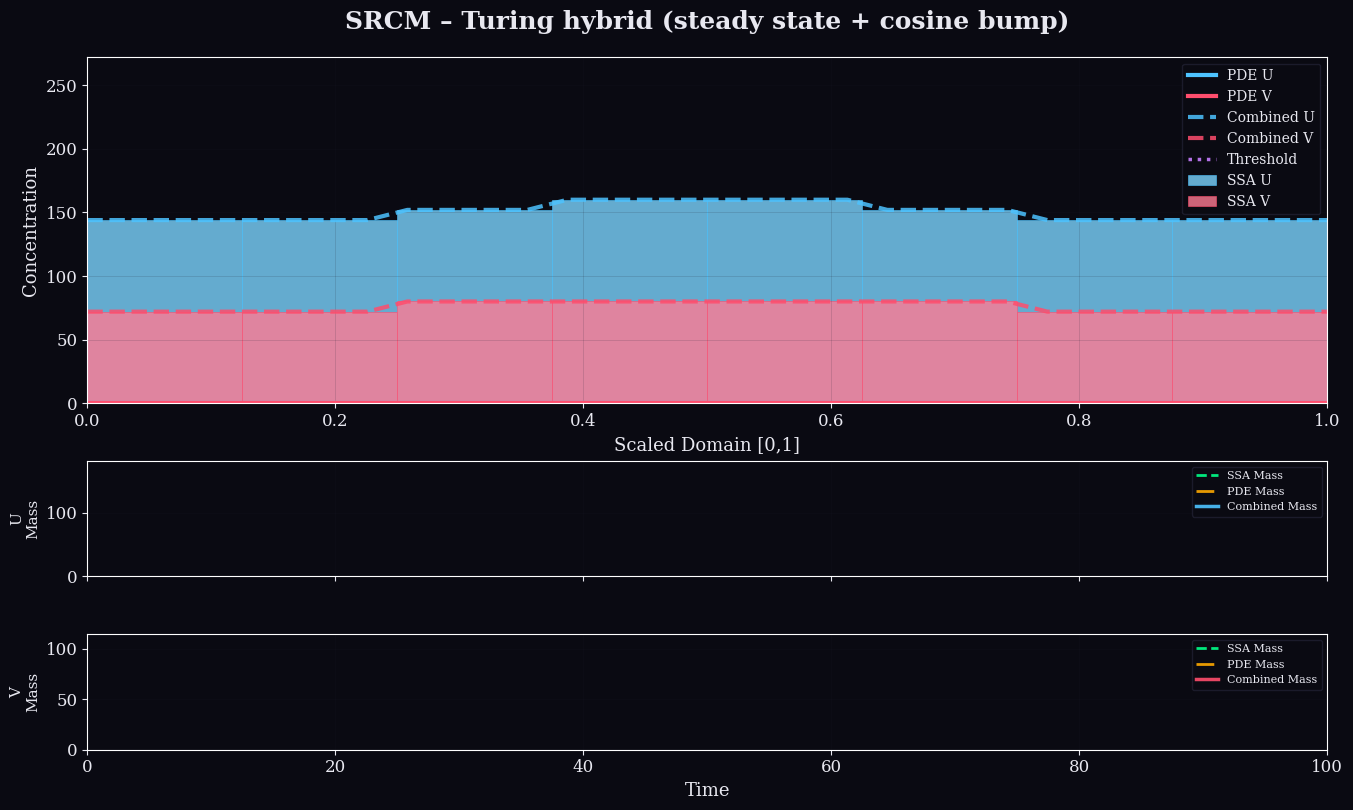

In [13]:
cfg = AnimationConfig(
    stride=20,
    interval_ms=20,
    threshold_particles=threshold_particles,
    title="SRCM – Turing hybrid (steady state + cosine bump)",
    mass_plot_mode="per_species",
)
animate_results(res_mean, cfg=cfg)


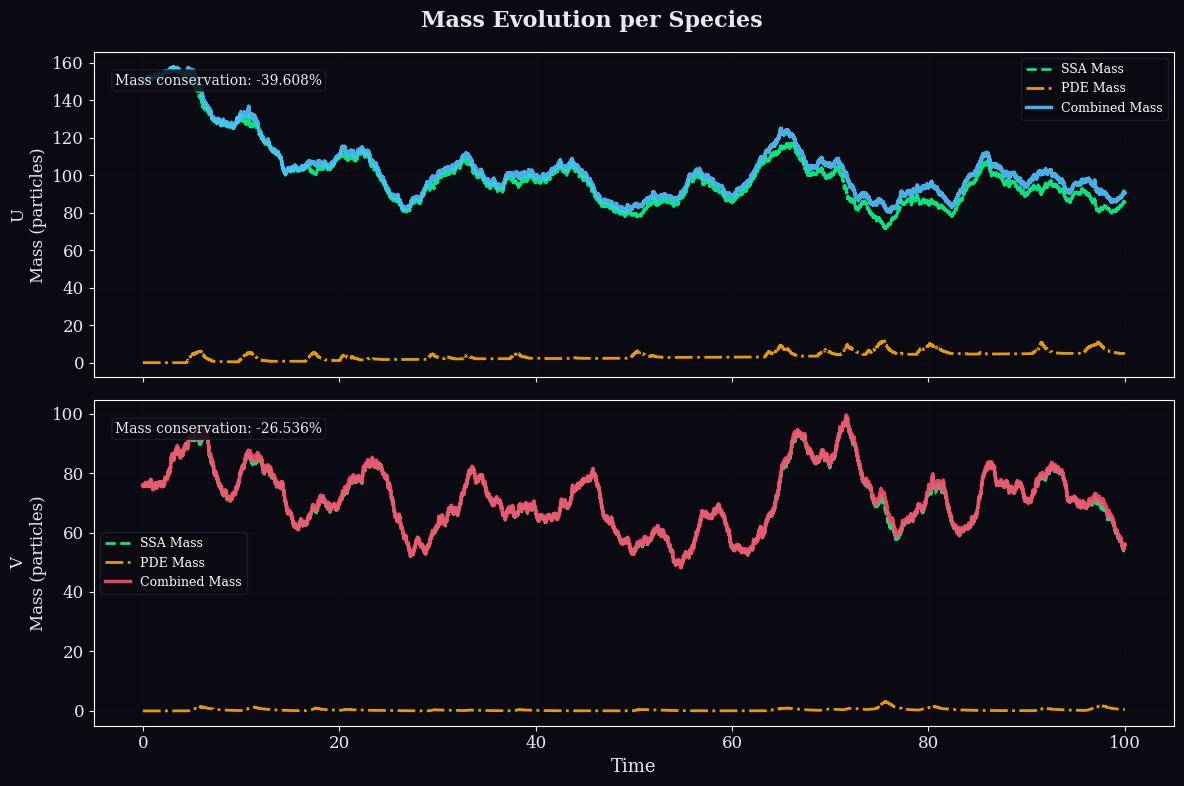

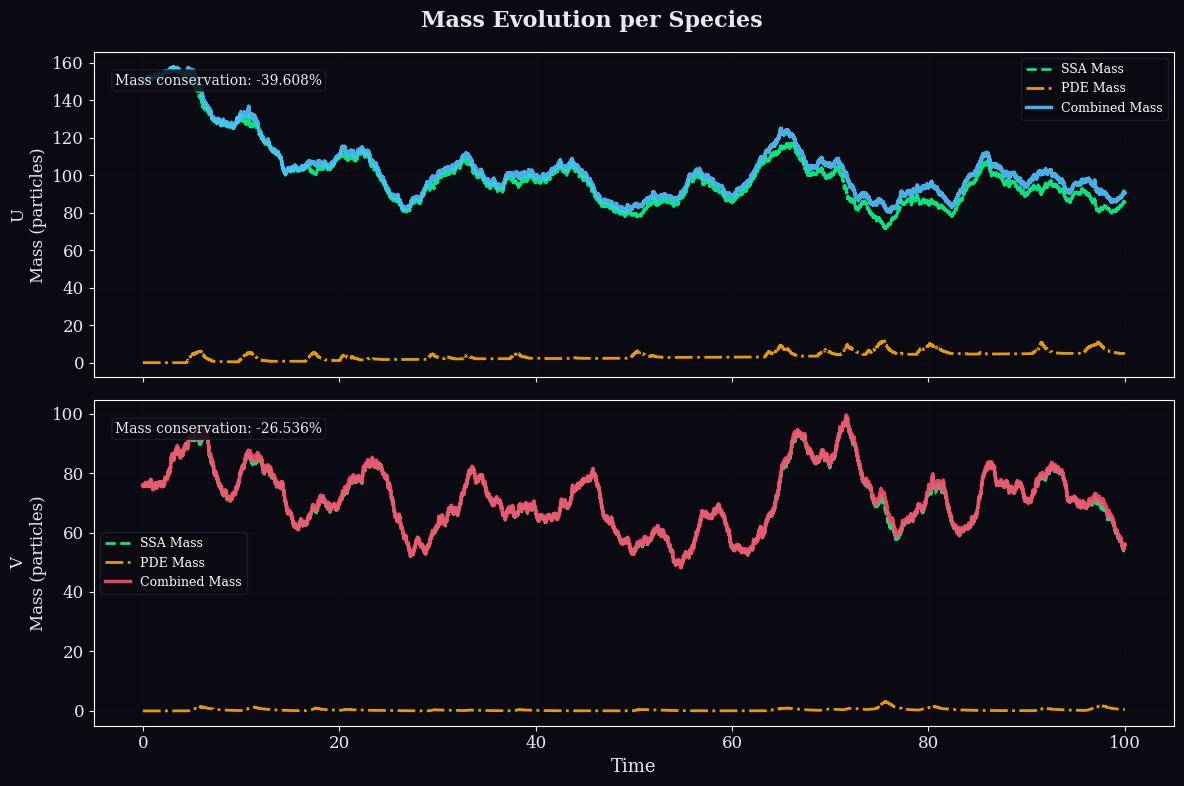

In [14]:
plot_mass_time_series(res_mean, plot_mode='per_species')

## 6) Reload later (optional)

In [ ]:
loaded_res, loaded_meta = load_npz(out_npz)
print('omega:', loaded_meta.get('omega'))
print('reaction_rates:', loaded_meta.get('reaction_rates'))
